# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [2]:
# Load CIFAR 10
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset

# Load CIFAR 10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

ds_train = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
ds_test = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

batch_size = 64
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False)

# Load a subset of CIFAR 100 using torch.utils.data.Subset
# ds_train_100 = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
ds_test_100 = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)

# define cifar 10 classes
cifar_10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get 10 random number from 0 to 100
np.random.seed(0)
test_indices = np.random.choice(100, 10, replace=False)
print(test_indices)

# Create subsets
subset_test_100 = Subset(ds_test_100, test_indices)

# Create data loaders
test_loader_100 = torch.utils.data.DataLoader(subset_test_100, batch_size=batch_size, shuffle=False)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[26 86  2 55 75 93 16 73 54 95]


In [3]:
class CNN (nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [11]:
# load the model from the pth
model.load_state_dict(torch.load('cifar10_CNN.pth')) # weights from Moodle

<All keys matched successfully>

In [18]:
model.eval()
y_gt, y_pred = [], []
for i, data in enumerate(test_loader):
    x, y = data
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    y_pred.append(y_hat.argmax(dim=1).cpu())
    y_gt.append(y.cpu())

Accuracy on CIFAR 10 test set: 0.10


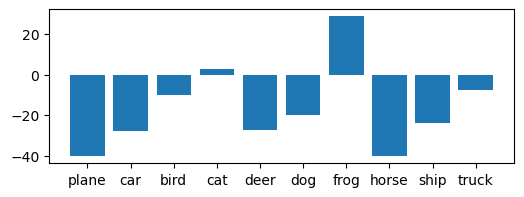

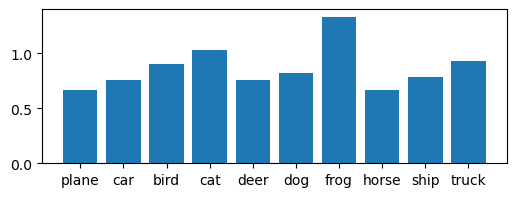

In [35]:
y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)
accuracy = sum(y_pred_t == y_gt_t) / len(y_gt_t)
print(f'Accuracy on CIFAR 10 test set: {accuracy:.2f}')

# plot logits  
plt.figure(figsize=(6, 2))
plt.bar(cifar_10_classes, y_hat[0].detach().cpu().numpy())
plt.show()
temperture = 100
plt.figure(figsize=(6, 2))  
plt.bar(cifar_10_classes, (y_hat[0] / temperture).exp().detach().cpu().numpy())
plt.show()

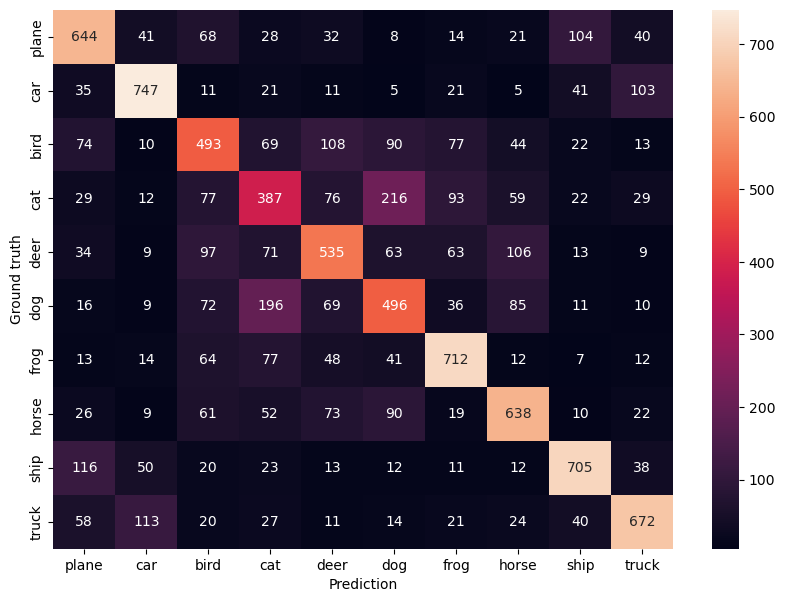

In [24]:
# use scikit-learn to compute the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_gt_t, y_pred_t)
# plot using seaborn
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=cifar_10_classes, yticklabels=cifar_10_classes)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


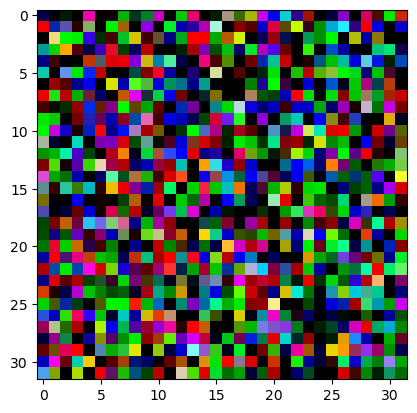

In [43]:
# Downloading fake data
ds_fake = torchvision.datasets.FakeData(size=1000, image_size=(3, 32, 32), transform=transform)
fake_loader = torch.utils.data.DataLoader(ds_fake, batch_size=batch_size, shuffle=True)

# Print an image from the fake data using plt
for i, data in enumerate(fake_loader):
    x, y = data
    plt.imshow(np.transpose(x[0], (1, 2, 0)))
    plt.show()
    break

Accuracy on FakeData set: 0.10


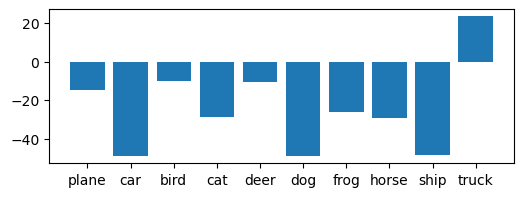

C:\Users\super\AppData\Local\Temp\ipykernel_13516\3486662789.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.bar(cifar_10_classes, F.softmax(y_hat[0] / temperture).detach().cpu().numpy())


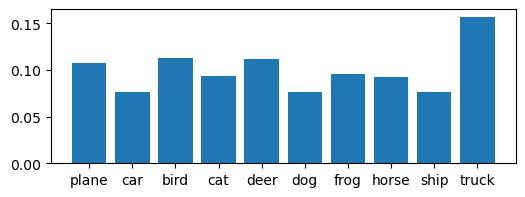

In [44]:
# See how the model performs on the fake data
model.eval()
y_gt, y_pred = [], []
for i, data in enumerate(fake_loader):
    x, y = data
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    y_pred.append(y_hat.argmax(dim=1).cpu())
    y_gt.append(y.cpu())

y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)
accuracy = sum(y_pred_t == y_gt_t) / len(y_gt_t)
print(f'Accuracy on FakeData set: {accuracy:.2f}')

# plot logits  
plt.figure(figsize=(6, 2))
plt.bar(cifar_10_classes, y_hat[0].detach().cpu().numpy())
plt.show()
temperture = 100
plt.figure(figsize=(6, 2))  
plt.bar(cifar_10_classes, F.softmax(y_hat[0] / temperture).detach().cpu().numpy())
plt.show()

In [58]:
def max_logit(logits):
    return logits.max(1)[0]
def compute_scores(dataloader, score_fun):
    scores = []
    for data in dataloader:
        x, y = data
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        s = score_fun(y_hat)
        scores.append(s)
    return torch.cat(scores)

In [81]:
scores_t = compute_scores(test_loader, max_logit)
scores_fake = compute_scores(fake_loader, max_logit)
print(scores_t.shape)
print(scores_fake.shape)

torch.Size([10000])
torch.Size([1000])


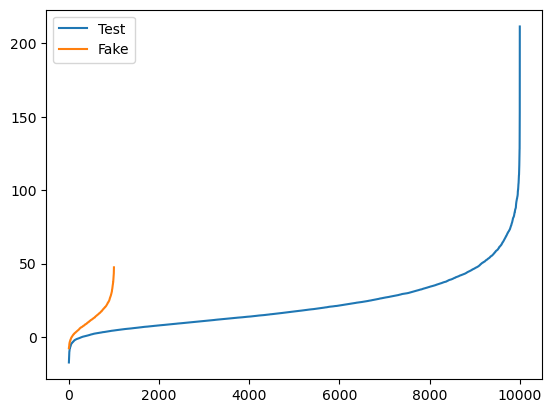

In [82]:
# Plot scores
plt.plot(sorted(scores_t.detach().cpu()), label='Test')
plt.plot(sorted(scores_fake.detach().cpu()), label='Fake')
plt.legend()
plt.show()

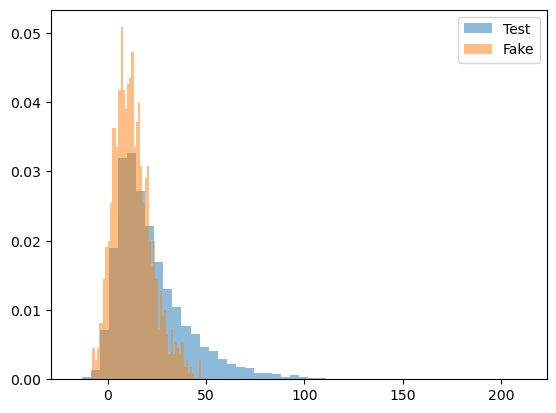

In [83]:
# plot histogram of scores
plt.hist(scores_t.detach().cpu(), bins=50, alpha=0.5, label='Test', density=True)
plt.hist(scores_fake.detach().cpu(), bins=50, alpha=0.5, label='Fake', density=True)
plt.legend()
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


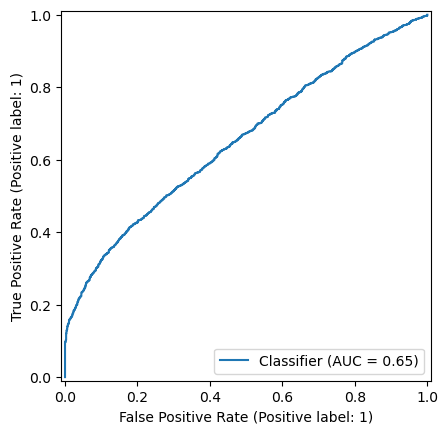

In [84]:
# plot ROC curve
from sklearn.metrics import RocCurveDisplay

scores_pred = torch.cat([scores_t, scores_fake])
y_true = torch.cat([torch.ones_like(scores_t), torch.zeros_like(scores_fake)]) 

roc = RocCurveDisplay.from_predictions(y_true.cpu().detach().numpy(), scores_pred.cpu().detach().numpy())


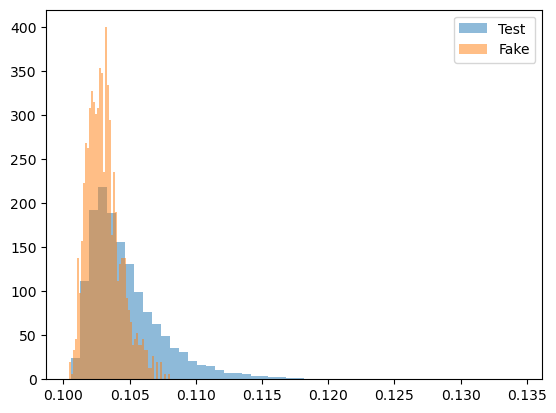

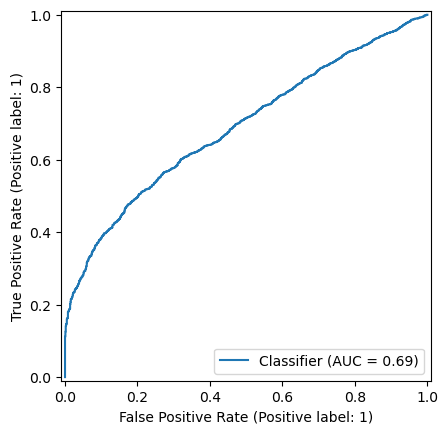

In [94]:
# Changing the score function to max_softmax
def max_softmax(logit, T = 1.0):
    s = F.softmax(logit / T, dim=1)
    return s.max(1)[0]

scores_t = compute_scores(test_loader, lambda x: max_softmax(x, 1000))
scores_fake = compute_scores(fake_loader, lambda x: max_softmax(x, 1000))

# plot histogram of scores
plt.hist(scores_t.detach().cpu(), bins=50, alpha=0.5, label='Test', density=True)
plt.hist(scores_fake.detach().cpu(), bins=50, alpha=0.5, label='Fake', density=True)
plt.legend()
plt.show()

# plot ROC curve
scores_pred = torch.cat([scores_t, scores_fake])
roc = RocCurveDisplay.from_predictions(y_true.cpu().detach().numpy(), scores_pred.cpu().detach().numpy())

> TODO: train a brand new model from scratch for just few epochs

> TODO: si può usare un autoencoder per fare queste cose

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [6]:
# Your code here.
# Prendere modello, fare forward, poi prendere gradiente e calcolare segno del gradiente (requir_grad)
# Derivare loss rispetto a x e calcolare segno del gradiente
# Mettere epsilon piccolo e vedere se il classificatore sbaglia
# Usare adv samples stile gan (per ogni elemento del batch far vedere un esempio adversarial, le etichette sono le stesse)

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [7]:
# Your code here.

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.
